In [1]:
from KoopmanismResponse.dynamical_systems.Models import one_dim_map
from KoopmanismResponse.EDMD.EDMD import Edmd_Fourier
from KoopmanismResponse.utils.data_processing import get_spectral_properties, get_acf , Koopman_correlation_function
from KoopmanismResponse.utils.paths import get_data_folder_path
from KoopmanismResponse.utils.data_processing import get_observables_response_1dMap
from matplotlib import pyplot as plt
import numpy as np
import pickle

In [2]:
one_map = one_dim_map()
one_map.set_random_initial_condition()
one_map.M = 10**6
t, x = one_map.integrate()

100%|██████████| 1000000/1000000 [00:01<00:00, 523039.37it/s]


Text(0.5, 0, 'x')

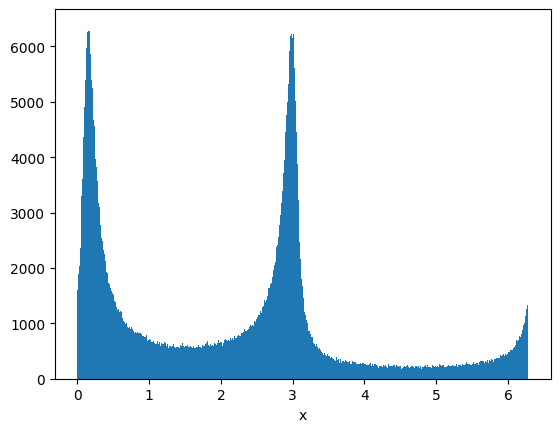

In [3]:
L = int( np.sqrt(len(x)) ) 
plt.hist(x,bins=L)
plt.xlabel("x")

In [4]:
# Set the EDMD algorithm
edmd = Edmd_Fourier()
edmd.dimension = 1
edmd.max_wave_vector = 30
edmd._set_indices()

In [5]:
# Perform algorithm and get spectral properties
K = edmd.perform_edmd(data=x)
nus, V, W = get_spectral_properties(K)

100%|██████████| 100/100 [00:03<00:00, 32.68it/s]


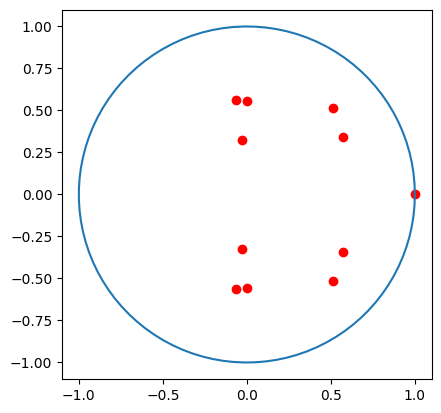

In [6]:
nus_plot = nus[:11]
fig, ax = plt.subplots()
thetas = np.linspace(0,2*np.pi,100)
ax.plot(np.cos(thetas),np.sin(thetas))
ax.scatter(np.real(nus_plot), np.imag(nus_plot),color='r')
ax.set_aspect('equal')

Text(0.5, 0, '$t$')

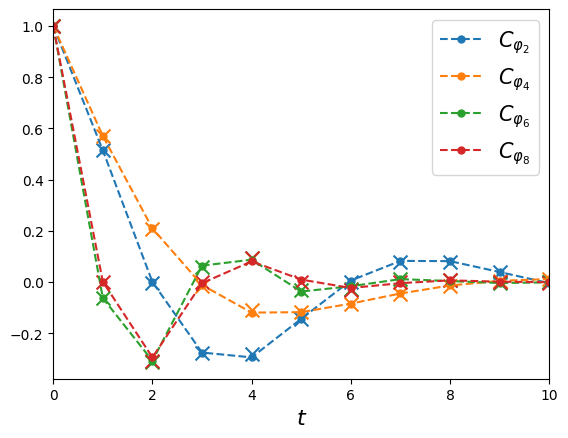

In [7]:
numbers = [1,3,5,7]
nlags = 30
Phi_traj = edmd.evaluate_koopman_eigenfunctions_batch(x,V)
fig , ax = plt.subplots()

for i,number in enumerate(numbers):
    lags, cf = get_acf(Phi_traj[:,number], nlags = nlags,Dt=1)
    cf_th = np.real( nus[number]**lags )
    ax.plot(lags,cf/cf[0],'--o',label= fr"$C_{{ \varphi_{number+1} }}$",markersize=5 )
    ax.scatter(lags,cf_th /cf_th[0],marker= 'x',s=100 )
    ax.set_xlim(0,10)
    
ax.legend(fontsize=15)
ax.set_xlabel("$t$",size=16)   

In [8]:
### General observables
observables = [x , np.sin(x)**2, np.abs(np.log(x+0.1))] 
cf_num = [get_acf(obs,nlags = nlags,Dt=1)[1] for obs in observables]

### Projections with Lebesgue
grid = np.linspace(0,2*np.pi,1000)
observables_grid = [grid, np.sin(grid)**2 , np.abs(np.log(grid+0.1))]
dV = grid[1] - grid[0]
Psi_Lebesgue = edmd.evaluate_dictionary_batch(grid)
G_Leb = Psi_Lebesgue.T.conj() @ Psi_Lebesgue * dV
projections =  [np.linalg.pinv(G_Leb) @ ( Psi_Lebesgue.T.conj() @ obs * dV) for obs in observables_grid] 

# Evaluate the Koopman projections and the reconstruction
Koop_projections = [W.conj().T @ proj for proj in projections]
M = V.conj().T @ edmd.G @ V 
Koop_reconstruction = [
    lambda t, koop_proj=koop_proj: Koopman_correlation_function(
        t=t, M=M.T, eigenvalues=nus, alpha1=koop_proj, alpha2=koop_proj
    ) for koop_proj in Koop_projections
]

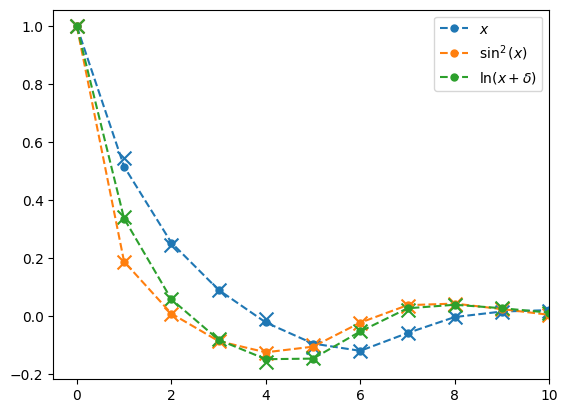

In [9]:
fig, ax = plt.subplots()
labels = [f"$x$", f"$\sin^2(x)$" , f"$\ln(x+\delta)$"]
for cf, Koop_rec,label  in zip( cf_num , Koop_reconstruction, labels):
    Koop_cf = np.real( np.asarray( [Koop_rec(lag) for lag in lags] ) )

    ax.plot(lags,cf/ cf[0],'--o',markersize=5,label=label)
    ax.scatter(lags,Koop_cf/Koop_cf[0],s=100,marker="x")

ax.set_xlim(-0.5,10)
ax.legend()

In [10]:
data_folder_path = get_data_folder_path()
f_name = "response_one_dimensional_map.pkl"

with open(data_folder_path / f_name,"rb") as f:
    response_experiments_results = pickle.load(f)

RP = response_experiments_results["Positive Response"]
RM = response_experiments_results["Negative Response"]
amplitudes = response_experiments_results["Amplitudes"]
response_settings = response_experiments_results["Response Settings"]

t_resp = np.arange(1,response_settings.M+1)
G = np.zeros(RP[0].shape)
for rp , rm , amplitude in zip(RP,RM,amplitudes):
    G +=  (rp - rm) / (2*amplitude) 
G /= len(amplitudes)

In [11]:
# Projections of observables on a grid
obs_grid = get_observables_response_1dMap(grid)
projections =  [np.linalg.pinv(G_Leb) @ ( Psi_Lebesgue.T.conj() @ obs * dV) for obs in obs_grid.T] 
# Evaluate the Koopman projections and the reconstruction
Koop_projections = [W.conj().T @ proj for proj in projections]

In [12]:
# Get the projection of \Gamma with respect to the invariant measure
# First we get the "moments"
Gamma_data = one_dim_map()
Gamma_data.M = 10**5
Gamma_data.set_random_initial_condition()
t, x_Gamma = Gamma_data.integrate()

100%|██████████| 100000/100000 [00:00<00:00, 498725.81it/s]


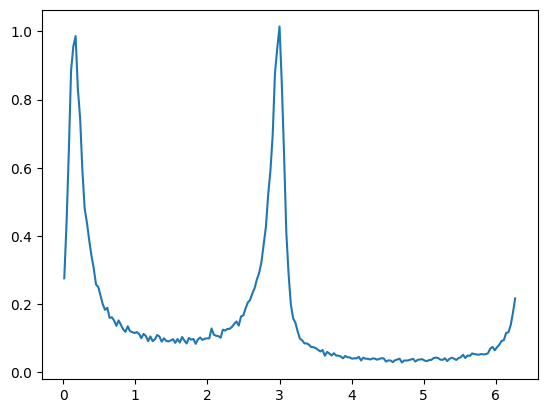

In [13]:
rho0 , bin_edges = np.histogram(x_Gamma,bins=200,density=True)
grid_rho0 = np.asarray( [ (bin_edges[i+1] + bin_edges[i] )/2 for i in range(len(bin_edges)-1)] )
dV = bin_edges[1] - bin_edges[0] 
plt.plot(grid_rho0,rho0)

In [14]:
# Evaluate the projections onto the dictionary of - ln(\rho_0)
g = -np.log(rho0)
Psi_grid_rho0 = edmd.evaluate_dictionary_batch(grid_rho0)
g_dictionary_projections = np.linalg.pinv(G_Leb) @ ( Psi_grid_rho0.T.conj() @ (g * dV) )

# Taking spectral derivative
wave_vectors = [k[0] for k in edmd.indices]
Gamma_dictionary_projections = [1j * k * proj for k,proj in zip(wave_vectors,g_dictionary_projections)]

# Finding projections of Gamma onto the Koopman eigenfunctions
Gamma_Koopman_projections = W.conj().T @ Gamma_dictionary_projections

In [15]:
Koop_reconstruction = [
    lambda t, koop_proj=koop_proj: Koopman_correlation_function(
        t=t, M=M.T, eigenvalues=nus, alpha1=koop_proj, alpha2=Gamma_Koopman_projections
    ) for koop_proj in Koop_projections
]

G_reconstruction = np.stack( [np.real( np.asarray( [Koop_rec(t) for t in t_resp] ) ) for Koop_rec in Koop_reconstruction] ).T

(-0.5, 15.0)

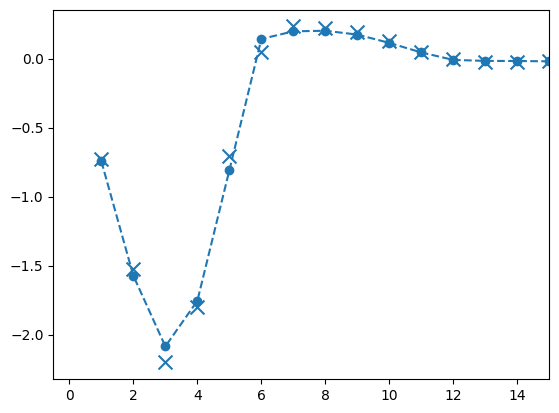

In [16]:
fig, ax = plt.subplots()
i = 0
ax.plot(t_resp,G[:,i],'--o')
ax.scatter(t_resp,G_reconstruction[:,i],s=100,marker="x")
ax.set_xlim(-0.5,15)